# Multiclass image classification

Here we'll modify binary image classification from previous example to multiclass image classification by detecting left diagonal and right diagonal separately.

In [ ]:
#|code-fold: true
#|output: false
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from pytorched.step_by_step import StepByStep
import platform
from PIL import Image
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

In [ ]:
#|code-fold: true 
def show_image(im, cmap=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(im, cmap=cmap)
    plt.grid(False)
    plt.show()

# Data

In [ ]:
#|code-fold: true
def gen_img(start, target, fill=1, img_size=10):
    # Generates empty image
    img = np.zeros((img_size, img_size), dtype=float)

    start_row, start_col = None, None

    if start > 0:
        start_row = start
    else:
        start_col = np.abs(start)

    if target == 0:
        if start_row is None:
            img[:, start_col] = fill
        else:
            img[start_row, :] = fill
    else:
        if start_col == 0:
            start_col = 1
        
        if target == 1:
            if start_row is not None:
                up = (range(start_row, -1, -1), 
                      range(0, start_row + 1))
            else:
                up = (range(img_size - 1, start_col - 1, -1), 
                      range(start_col, img_size))
            img[up] = fill
        else:
            if start_row is not None:
                down = (range(start_row, img_size, 1), 
                        range(0, img_size - start_row))
            else:
                down = (range(0, img_size - 1 - start_col + 1), 
                        range(start_col, img_size))
            img[down] = fill
    
    return 255 * img.reshape(1, img_size, img_size)


def generate_dataset(img_size=10, n_images=100, binary=True, seed=17):
    np.random.seed(seed)

    starts = np.random.randint(-(img_size - 1), img_size, size=(n_images,))
    targets = np.random.randint(0, 3, size=(n_images,))
    
    images = np.array([gen_img(s, t, img_size=img_size) 
                       for s, t in zip(starts, targets)], dtype=np.uint8)
    
    if binary:
        targets = (targets > 0).astype(int)
    
    return images, targets

def plot_images(images, targets, n_plot=30, per_row=10):
    n_rows = n_plot // per_row + ((n_plot % per_row) > 0)
    fig, axes = plt.subplots(n_rows, per_row, figsize=(9, 1.5 * n_rows))
    axes = np.atleast_2d(axes)
    
    for i, (image, target) in enumerate(zip(images[:n_plot], targets[:n_plot])):
        row, col = i // per_row, i % per_row    
        ax = axes[row, col]
        ax.set_title('#{} - Label:{}'.format(i, target), {'size': 8})
        # plot filter channel in grayscale
        ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.label_outer()

    plt.tight_layout()
    return fig

In [ ]:
images, labels = generate_dataset(img_size=10, n_images=1000, binary=False, seed=13)

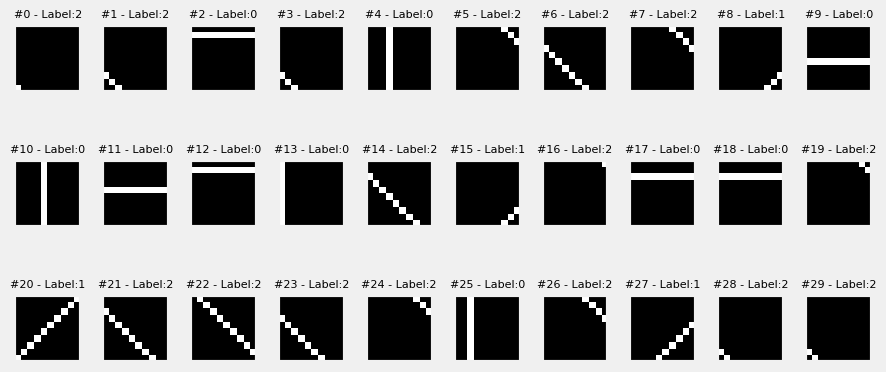

In [ ]:
fig = plot_images(images, labels, n_plot=30)

# Data preparation

We prepare data similary as in the previous exercize thought notable difference is that `y_tensor` shape is (N), not (N,1) as previously. This is due to loss function (`CrossEntropyLoss`) requiremnts (it takes class indices).

In [ ]:
x_tensor = torch.as_tensor(images / 255.).float()
y_tensor = torch.as_tensor(labels).long()

In [ ]:
x_tensor.shape

torch.Size([1000, 1, 10, 10])

In [ ]:
y_tensor.shape

torch.Size([1000])

In [ ]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

In [ ]:
torch.manual_seed(42)
N = len(x_tensor)
n_train = int(.8*N)
train_subset, val_subset = random_split(x_tensor, [n_train, N - n_train])
train_idx = train_subset.indices
val_idx = val_subset.indices

We do not apply augmentation since it would mess up the labels:

In [ ]:
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

Now we can build train/val `tensors`, `Dataset`s and `DataLoader`s:

In [ ]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [ ]:
y_val_tensor

tensor([2, 0, 2, 1, 0, 0, 0, 1, 1, 2, 1, 2, 0, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 1,
        2, 1, 2, 2, 0, 0, 1, 1, 0, 0, 1, 1, 2, 0, 2, 1, 1, 1, 2, 1, 0, 0, 0, 2,
        0, 2, 0, 2, 2, 2, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 2, 1, 0, 1, 0,
        2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2,
        2, 2, 0, 2, 2, 1, 2, 1, 1, 0, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 1,
        1, 1, 2, 2, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 2, 2, 1, 0, 2, 2, 2, 1, 1, 1,
        0, 1, 0, 2, 0, 2, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 2,
        2, 1, 1, 0, 2, 2, 1, 1, 0, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 1, 0, 0, 2, 0,
        0, 0, 0, 2, 2, 2, 2, 2])

# Deep model

A typical architecture uses a sequence of one or more typical convolutional blocks, with each block consisting of three operations:  

- Convolution

- Activation function

- Pooling

And for multiclass problems we need to use appropriate loss functions depending if we have Sigmoid/LogSoftmax as the last layer:

![](images/loss_table.jpg)

Let's build a model:


In [ ]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

Let's just run one batch to get the sense for loss:

In [ ]:
x, y = next(iter(train_loader))
y_pred = model_cnn1(x)
print(y.shape)
print(y_pred.shape)
nn.CrossEntropyLoss()(y_pred,y)

torch.Size([16])
torch.Size([16, 3])


tensor(0.2768, grad_fn=<NllLossBackward0>)

One important observation: `y` shape is 16, while `y_pred` shape is 16x3. `CrossEntropyLoss` expects this (see [docs](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).

In [ ]:
sbs = StepByStep(model_cnn1, optimizer_cnn1, multi_loss_fn)
# sbs.set_seed()
sbs.set_loaders(train_loader, val_loader)
sbs.train(20)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.16it/s]


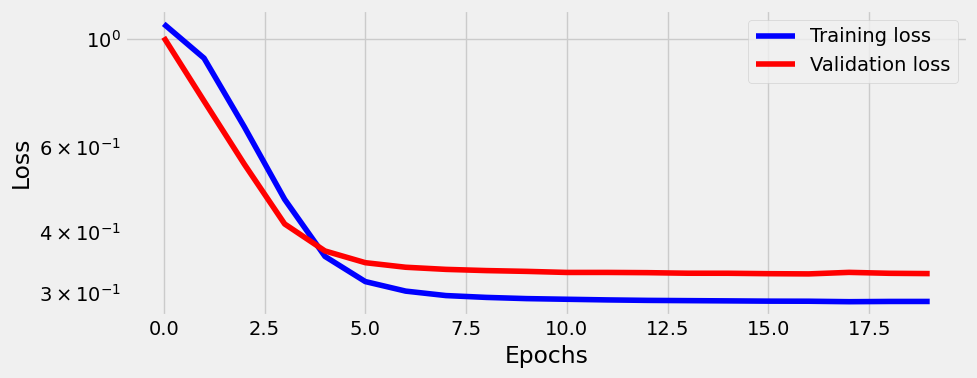

In [ ]:
fig = sbs.plot_losses()

In [ ]:
#|code-fold: true
print('Correct categories:')
print(sbs.loader_apply(sbs.val_loader, sbs.correct))

Correct categories:
tensor([[60, 71],
        [46, 56],
        [73, 73]])


In [ ]:
#|code-fold: true 
print(f'Accuracy: {sbs.accuracy}%')

Accuracy: 89.5%


This is not the greatest accuracy for label 0 (parallel) and label 1 (counter-diagonal). Once can probably find a better model (TODO) but for now let's inspect what failed.

# Visualize error outputs

In [ ]:
# will predict all points at once here, no batches:
logits = sbs.predict(val_loader.dataset.x)
predicted = np.argmax(logits, 1)

In [ ]:
logits.shape

(200, 3)

In [ ]:
val_loader.dataset.x.shape

torch.Size([200, 1, 10, 10])

In [ ]:
logits.shape

(200, 3)

In [ ]:
predicted

array([2, 0, 2, 1, 0, 0, 0, 1, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       0, 1, 2, 1, 2, 2, 0, 0, 1, 2, 0, 0, 1, 1, 2, 0, 2, 1, 1, 1, 2, 1,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0, 0, 0,
       1, 2, 1, 2, 1, 0, 2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0, 1, 2, 0, 2, 1,
       2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1,
       1, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 2, 1, 1, 2,
       0, 0, 2, 2, 1, 0, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 2, 1, 2, 2, 0,
       2, 0, 0, 0, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 2, 0, 2, 2, 1, 1,
       0, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 1, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2,
       2, 2])

In [ ]:
not_equal = torch.ne(val_loader.dataset.y, torch.as_tensor(predicted))
images_tensor = val_loader.dataset.x[not_equal]
actual_labels_tensor = val_loader.dataset.y[not_equal]
pred_labels_tensor = predicted[not_equal]

In [ ]:
#| hide
assert sbs.visualization == {}

In [ ]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']
classifier_layers = ['fc1', 'relu2', 'fc2']

sbs.attach_hooks(layers_to_hook=featurizer_layers + classifier_layers)

start_idx = 0
batch_size = 10
images_batch = images_tensor[start_idx:start_idx+batch_size]
labels_batch = actual_labels_tensor[start_idx:start_idx+batch_size]

logits = sbs.predict(images_batch)
predicted = np.argmax(logits, 1)
sbs.remove_hooks()

In [ ]:
#| hide
assert sbs.visualization['conv1'].shape[0] == batch_size

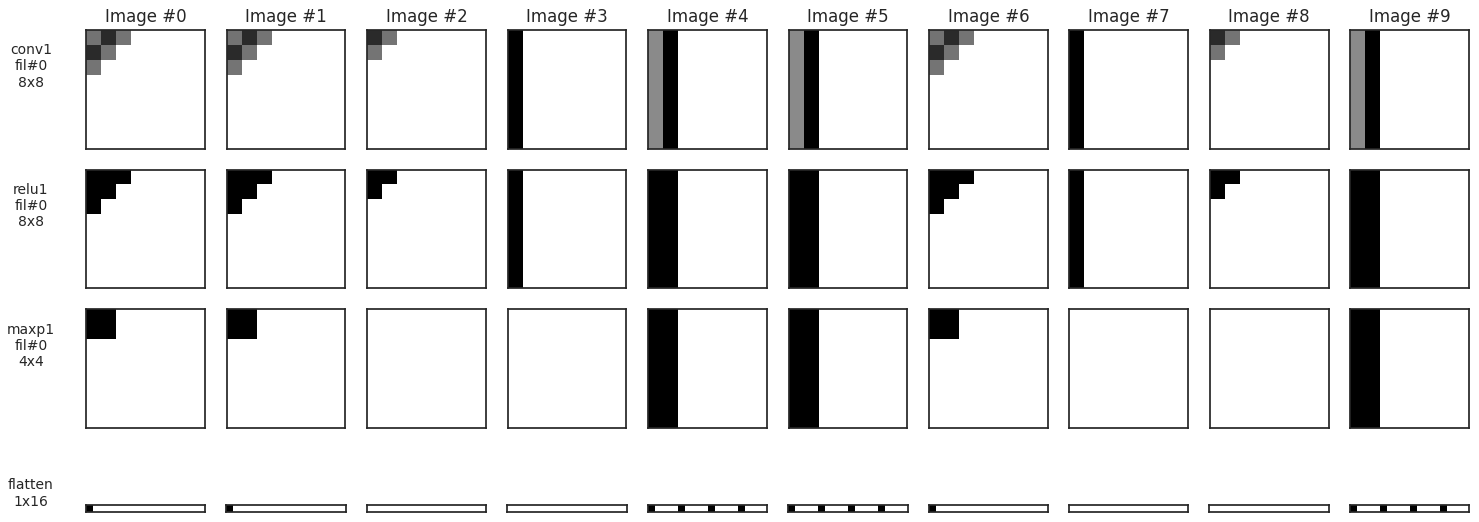

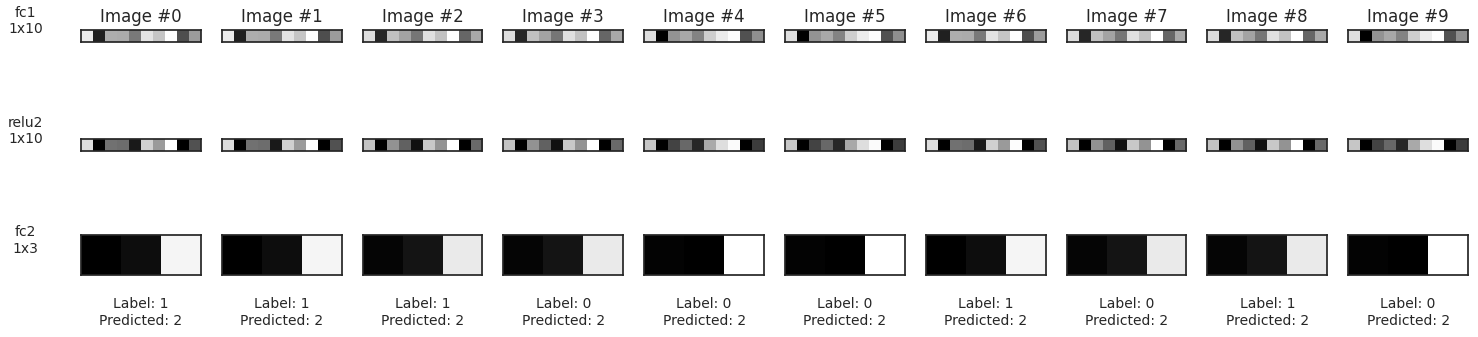

In [ ]:
with plt.style.context('seaborn-white'):
    fig_maps1 = sbs.visualize_outputs(featurizer_layers)
    fig_maps2 = sbs.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)    

And we see that lots of predictions are for class label 2. For images 2,3,7,8, filters failed to register anything. 

# Ordinary batch visualization:

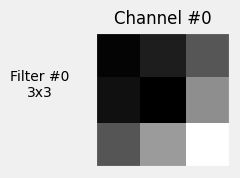

In [ ]:
fig_filters = sbs.visualize_filters('conv1', cmap='gray')

In [ ]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']
classifier_layers = ['fc1', 'relu2', 'fc2']

sbs.attach_hooks(layers_to_hook=featurizer_layers + classifier_layers)

images_batch, labels_batch = next(iter(val_loader))
logits = sbs.predict(images_batch)
predicted = np.argmax(logits, 1)
sbs.remove_hooks()

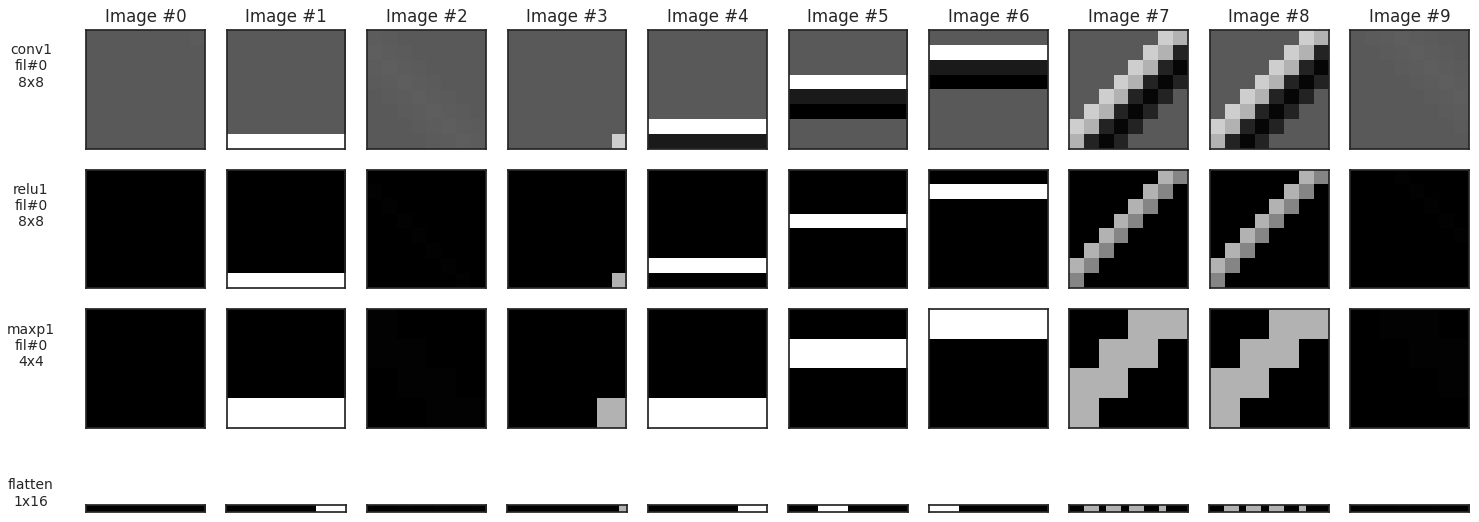

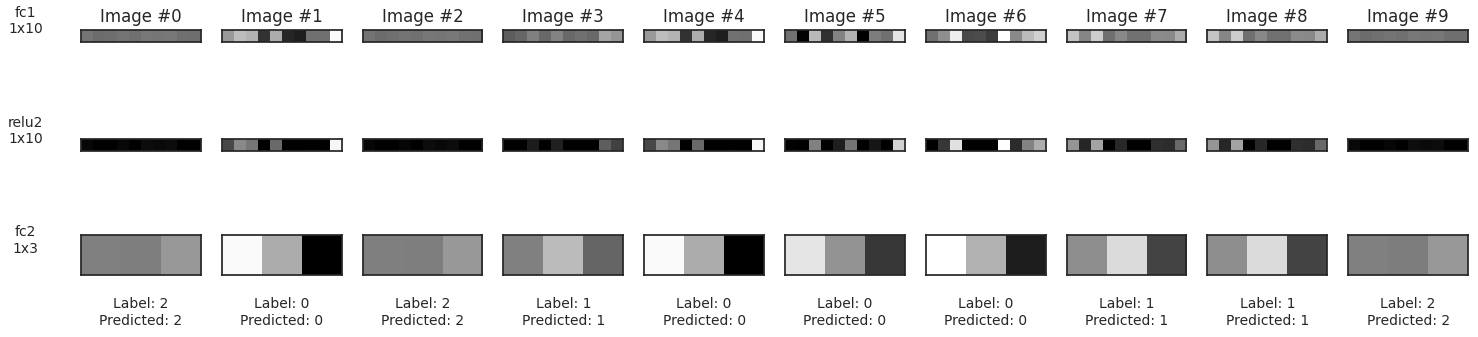

In [ ]:
with plt.style.context('seaborn-white'):
    fig_maps1 = sbs.visualize_outputs(featurizer_layers)
    fig_maps2 = sbs.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)